# Quasi static forces from model test

# Purpose
Calculating the quasi static forces from a model test by assuming the added masses. This can then be compared to the static VCT calculations.

# Setup

In [1]:
# %load imports.py
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt
#if os.name == 'nt':
#    plt.style.use('presentation.mplstyle')  # Windows

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl
from src.models import linear_vmm
import src.nonlinear_vmm_equations as eq
#import src.models.linear_vmm as model
from src.symbols import *
import src.symbols as symbols
from src import prime_system
from src.models import regression
from src.visualization.plot import track_plot
from src.equation import Equation

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


# Methodology
Generally:

$ F = m \cdot a $

if $m$ (including added mass) can is known $F$ should be possible to calculate from a dynamic model test.

For the ship in the Y-direction this can be written as:

In [2]:
Equation(eq.Y_eom)

<src.equation.Equation object>

In [3]:
Equation(eq.Y_eq)

<src.equation.Equation object>

where $Y_{qs}$ is the quasi static force that can be obtained from the model tests as:

In [4]:
eq_Y_qs = sp.Eq(Y_qs,
      sp.solve(eq.Y_eq, Y_qs)[0])
Equation(eq_Y_qs)

<src.equation.Equation object>

In [5]:
subs = {value:key for key,value in eq.p.items()}
Y_qs_lambda = lambdify(eq_Y_qs.subs(subs).rhs)

# Quasi static forces from model tests

## Load test

In [6]:
df_runs = mdl.runs()

In [29]:
#id=22773
#id=22616
#id=22774
id=22770


df, units, meta_data = mdl.load(id=id, dir_path='../data/processed/kalman')
df.index = df.index.total_seconds()
df = df.iloc[0:-100].copy()
df.index-=df.index[0]
df.sort_index(inplace=True)
df['-delta'] = -df['delta']

In [30]:
meta_data['rho']=1000
meta_data['mass'] = meta_data['Volume']*meta_data['rho']
meta_data.dropna()

A0                                                               0.722775
KXX                                                              0.331311
KZZ                                                              1.253641
TA                                                               0.206311
TF                                                               0.206311
Volume                                                           0.441027
angle1                                                               10.0
angle2                                                               10.0
beam                                                             0.946602
comment                                                        ZZ 10/10PS
date                                                           2020-09-24
facility                                                              MDL
file_path_hdf5          \\sspa.local\lab\MeasuredataMDL\40199079\005\0...
gm                                    

In [31]:
df.head()

,Arr/Ind/Arr,Arr/Ind/Fri,Fan/Aft/Angle,Fan/Aft/AngleOrder,Fan/Aft/Fx,Fan/Aft/FxOrder,Fan/Aft/Rpm,Fan/Aft/RpmOrder,Fan/ForceFactor,Fan/Fore/Angle,Fan/Fore/AngleOrder,Fan/Fore/Fx,Fan/Fore/FxOrder,Fan/Fore/Rpm,Fan/Fore/RpmOrder,Hull/Acc/X1,Hull/Acc/Y1,Hull/Acc/Y2,Hull/Acc/Z1,Hull/Acc/Z2,Hull/Acc/Z3,Prop/PS/Rpm,Prop/PS/Thrust,Prop/PS/Torque,Prop/SB/Rpm,Prop/SB/Thrust,Prop/SB/Torque,delta,Rudder/MaxAngle,Rudder/Rate,Wind/Course,Wind/CourseTreshold,Wind/GWA,lab/WaveHeight,roll,pitch,psi,x0,y0,z0,x01d_gradient,y01d_gradient,z01d_gradient,z02d_gradient,psi1d_gradient,x0_filtered,x01d,x02d,y0_filtered,y01d,y02d,psi_filtered,psi1d,psi2d,u,v,w,u1d,v1d,w1d,r,r1d,beta,-delta
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,0.0,1.0,2.146755,0.000930,0.244419,0.0,-0.520477,10.131507,1.0,2.146755,-0.024623,0.122683,0.0,2.144633,11.329219,-0.000651,-0.009621,-0.007185,-0.002344,0.006963,0.008156,9.597722,5.567396,-0.113822,9.546612,5.328476,0.104278,-0.000007,0.645772,14.89,-0.005037,0.1,0.0,0.000025,0.000927,0.000325,-0.000873,7.611185,-0.001594,0.002499,1.020600,-0.003508,-0.022730,1.867924,0.017441,7.630116,0.932272,0.000005,-0.001617,0.000065,-6.810068e-07,-0.000821,0.000001,-0.000004,0.932272,0.000830,-0.022730,0.000005,-6.766628e-07,1.867924,0.000001,-0.000004,-0.000890,0.000007
0.010007,0.0,1.0,2.146755,0.000832,0.121932,0.0,-0.288911,10.131507,1.0,2.146755,-0.022034,0.126699,0.0,1.025401,11.329219,0.012245,-0.012845,-0.014928,-0.012007,0.019213,0.003000,9.572657,5.679435,-0.110951,9.558256,5.397689,0.106811,-0.000007,0.645772,14.89,-0.004507,0.1,0.0,0.000025,0.000972,-0.000254,-0.000698,7.621398,-0.001629,0.002271,0.508139,0.000864,-0.004038,1.308212,0.013081,7.625826,0.921355,-0.002257,-0.001613,0.000114,-1.514633e-05,-0.000735,-0.000025,-0.000024,0.921354,0.000791,-0.004038,-0.002257,-1.680414e-05,1.308212,-0.000025,-0.000024,-0.000859,0.000007
0.020011,0.0,1.0,2.146755,0.000736,-0.120384,0.0,0.000545,10.131507,1.0,2.146755,-0.019471,0.025530,0.0,1.913068,11.329219,-0.001296,-0.012200,-0.029125,0.002810,0.021792,0.002356,9.514150,5.728091,-0.107321,9.562515,5.484805,0.109010,0.000000,0.645772,14.89,-0.003983,0.1,0.0,0.000025,0.000915,0.000341,-0.000611,7.621356,-0.001577,0.002418,0.952405,0.001934,0.003452,0.258792,-0.008754,7.627892,0.921396,-0.003307,-0.001587,0.000145,-2.490043e-05,-0.000702,-0.000131,-0.000054,0.921396,0.000792,0.003452,-0.003307,-2.722338e-05,0.258792,-0.000131,-0.000054,-0.000860,-0.000000
0.030001,0.0,1.0,2.146755,0.000638,-0.310377,0.0,0.521567,10.131507,1.0,2.146755,-0.016901,-0.089957,0.0,0.639459,11.329219,0.005152,-0.012845,-0.016219,-0.005565,0.007608,-0.001511,9.541821,5.700100,-0.104350,9.587783,5.548451,0.110168,0.000000,0.645772,14.89,-0.003457,0.1,0.0,0.000025,0.000945,-0.000327,-0.000873,7.640413,-0.001590,0.002341,1.483970,0.002393,0.001150,-0.262092,-0.008748,7.639433,0.923933,-0.002592,-0.001575,0.000151,-3.795793e-05,-0.000805,-0.000191,-0.000113,0.923932,0.000895,0.001150,-0.002592,-4.004497e-05,-0.262092,-0.000191,-0.000113,-0.000969,-0.000000
0.040001,0.0,1.0,2.146755,0.000549,-0.303348,0.0,0.463676,10.131507,1.0,2.146755,-0.014543,-0.130523,0.0,-0.749933,11.329219,0.007087,-0.017357,-0.023318,-0.001700,0.017924,-0.002155,9.514368,5.613694,-0.103258,9.562679,5.586684,0.110073,0.000000,0.645772,14.89,-0.002975,0.1,0.0,0.000025,0.000929,0.000426,-0.000785,7.651012,-0.001529,0.002441,0.931076,0.003854,-0.001788,0.240757,-0.000002,7.649572,0.924786,-0.002156,-0.001540,0.000128,-4.577976e-05,-0.000809,-0.000182,-0.000150,0.924785,0.000876,-0.001788,-0.002156,-4.752416e-05,0.240757,-0.000182,-0.000150,-0.000948,-0.000000


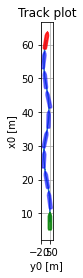

In [32]:
from src.visualization.plot import track_plot
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

# Ship parameters

In [33]:
T_ = (meta_data.TA + meta_data.TF)/2
L_ = meta_data.lpp
m_ = meta_data.mass
rho_ = meta_data.rho
B_ = meta_data.beam
CB_ = m_/(T_*B_*L_*rho_)
I_z_ = m_*meta_data.KZZ**2

ship_parameters = {
        'T' : T_,
        'L' : L_,
        'CB' :CB_,
        'B' : B_,
        'rho' : rho_,
        'x_G' : 0,  # motions are expressed at CG
        'm' : m_,
        'I_z': I_z_, 
    }

ps = prime_system.PrimeSystem(**ship_parameters)  # model

scale_factor = meta_data.scale_factor
ps_ship = prime_system.PrimeSystem(L=ship_parameters['L']*scale_factor, rho=meta_data['rho'])  # ship

# Brix parameters

In [34]:
def calculate_prime(row, ship_parameters):
    return run(function=row['brix_lambda'], inputs=ship_parameters)

mask = df_parameters['brix_lambda'].notnull()
df_parameters.loc[mask,'brix_prime'] = df_parameters.loc[mask].apply(calculate_prime, ship_parameters=ship_parameters, axis=1)
df_parameters.loc['Ydelta','brix_prime'] = 0.005  # Just guessing
df_parameters.loc['Ndelta','brix_prime'] = -df_parameters.loc['Ydelta','brix_prime']/2  # Just guessing
df_parameters['brix_prime'].fillna(0, inplace=True)

In [35]:
df['Y_qs'] = run(Y_qs_lambda, inputs=ship_parameters, **df, **df_parameters['brix_prime'])

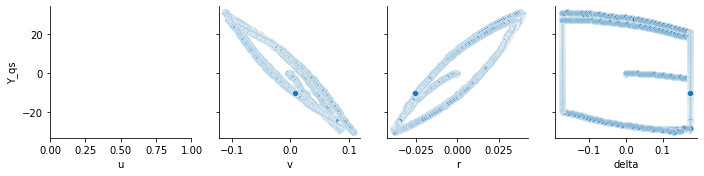

In [36]:
g = sns.PairGrid(df, x_vars=['u','v','r','delta'], y_vars=['Y_qs'])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

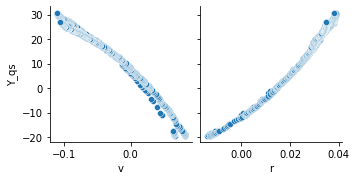

In [56]:
mask = df['delta'] <= df['delta'].quantile(q=0.01)
df_min = df.loc[mask].copy()
sns.pairplot(df_min, x_vars=['v','r'], y_vars=['Y_qs'])

<AxesSubplot:xlabel='time'>

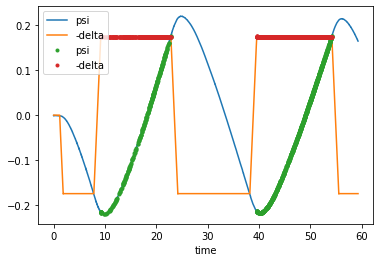

In [57]:
fig,ax=plt.subplots()
df.plot(y=['psi','-delta'], ax=ax)
df_min.plot(y=['psi','-delta'], style='.', ax=ax)

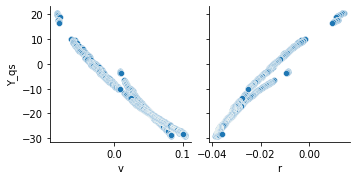

In [68]:
mask = df['delta'] >= df['delta'].quantile(q=0.85)
df_max = df.loc[mask].copy()
sns.pairplot(df_max, x_vars=['v','r'], y_vars=['Y_qs'])

<AxesSubplot:xlabel='time'>

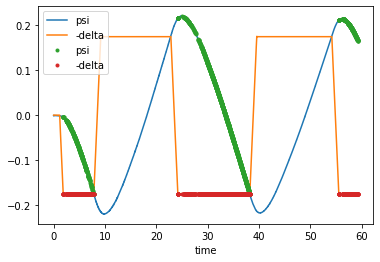

In [69]:
fig,ax=plt.subplots()
df.plot(y=['psi','-delta'], ax=ax)
df_max.plot(y=['psi','-delta'], style='.', ax=ax)